Stock prediction

Step 1: Import Necessary Libraries

<ipython-input-2-9b53b7f3754e>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(xs).float(), torch.tensor(ys).float()


Epoch 20/200, Loss: 0.2022
Epoch 40/200, Loss: 0.0316
Epoch 60/200, Loss: 0.0223
Epoch 80/200, Loss: 0.0175
Epoch 100/200, Loss: 0.0117
Epoch 120/200, Loss: 0.0062
Epoch 140/200, Loss: 0.0023
Epoch 160/200, Loss: 0.0010
Epoch 180/200, Loss: 0.0009
Epoch 200/200, Loss: 0.0009


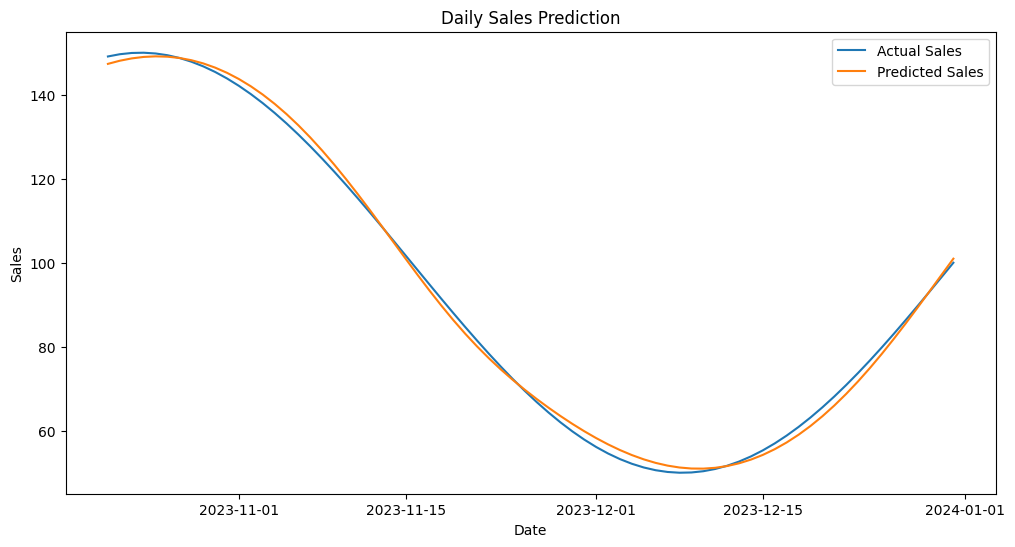

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ======================
# 1. Synthetic Data Preparation
# ======================
# Generate dummy data for 365 days
dates = pd.date_range(start='2023-01-01', periods=365, freq='D')
sales = np.sin(np.linspace(0, 8*np.pi, 365)) * 50 + 100  # Seasonal pattern
df = pd.DataFrame({'Date': dates, 'Daily_Sales': sales})

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df['Daily_Sales'].values.reshape(-1, 1))

# ======================
# 2. Create Sequences
# ======================
def create_sequences(data, seq_length=7):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs).float(), torch.tensor(ys).float()

seq_length = 7  # Use 7 days to predict next day
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ======================
# 3. Define RNN Model
# ======================
class SalesPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use last timestep output
        return out

model = SalesPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ======================
# 4. Training
# ======================
epochs = 200
for epoch in range(epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# ======================
# 5. Evaluation
# ======================
model.eval()
with torch.no_grad():
    test_preds = model(X_test)

# Inverse scaling
test_preds = scaler.inverse_transform(test_preds.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

# ======================
# 6. Visualization
# ======================
plt.figure(figsize=(12,6))
plt.plot(df['Date'][-len(y_test_actual):], y_test_actual, label='Actual Sales')
plt.plot(df['Date'][-len(test_preds):], test_preds, label='Predicted Sales')
plt.title('Daily Sales Prediction')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
